In [ ]:
import os
import time
import math 
import pandas as pd
import numpy as np
import cv2

# Sklearn
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Multiple print statments in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Adjust the Display options for number of rows and columns 
pd.set_option("display.max_columns", 500)
pd.set_option("display.min_rows", 500)

--------------
Implement a Denoising Autoencoder using three encoding and three decoding layers on the MNIST dataset for construction and reconstruction of the image. Use MSE as the loss function. <br>
a. Use 1 FC layer and 2 different activation functions of your choice for 10-class classification <br>
b. Use 3 FC layers and 2 different activation functions of your choice for 10-class classification <br>
c. Compare the performance between 1FC and 3FC layer results and report the accuracy on test set and plot loss curves on training and test dataset

**Loading the required libraries**

In [ ]:
import time
import math
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


from keras.datasets import mnist

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

In [ ]:
def f_Add_Noise(Image,Type_Of_Noise = 'Gaussian'):
    
    """In this function we will add noise to the images. Noise will be of two variety.
    In half images we will add Gaussian Noise and other half we will add the Salt-Pepper noise"""
    
    row,col=28,28 # In MNIST data we have 28*28 images
    image = Image.astype(np.float32)
    
    if Type_Of_Noise == 'Gaussian':
        
        mean = 0
        variance = 1
        std_dev = math.sqrt(variance)
        synthetic_noise = np.random.normal(loc = mean, scale = std_dev, size = image.shape).reshape(row,col)
        
        image = (image + synthetic_noise)
    
    elif Type_Of_Noise == 'Salt_Pepper':
        
        synthetic_noise = np.random.randn(row,col).reshape(row,col)
        
        image = (image + (image * synthetic_noise))
    
    else :
        print('Wrong slection for Noise Type!')
        
    return image

**Let's download the MNIST dataset**

In [ ]:
(X_train,y_train),(X_test,y_test) = mnist.load_data()

print(f'Train(X) || Shape || {X_train.shape}')
print(f'Train(y) || Shape || {y_train.shape}')
print('\n')
print(f'Test(X) || Shape || {X_test.shape}')
print(f'Test(y) || Shape || {y_test.shape}')

11501568/11490434 [==============================] - 0s 0us/step
Train(X) || Shape || (60000, 28, 28)
Train(y) || Shape || (60000,)


Test(X) || Shape || (10000, 28, 28)
Test(y) || Shape || (10000,)


**Adding noise to the training data set**

In [ ]:
%%time

# We will add Gaussian noise to half of the images in the training data and salt-pepper noise in the other half

Allowed_Noise_Types = ['Gaussian','Salt_Pepper']
Allowed_Noise_ID = 0
Counter = 0
df_train = np.zeros(X_train.shape)


for row_index in tqdm(range(len(X_train))):
    
    if Counter < round(len(X_train)/2):
        df_train[row_index] = f_Add_Noise(Image = X_train[row_index],Type_Of_Noise = Allowed_Noise_Types[Allowed_Noise_ID])
        Counter += 1
    else:
        Allowed_Noise_ID += 1
        Counter = 0


100%|██████████| 60000/60000 [00:03<00:00, 17122.84it/s]

CPU times: user 2.9 s, sys: 173 ms, total: 3.08 s
Wall time: 3.91 s


**Adding noise to the test data set**

In [ ]:
%%time

# We will add Gaussian noise to half of the images in the test data and salt-pepper noise in the other half

Allowed_Noise_Types = ['Gaussian','Salt_Pepper']
Allowed_Noise_ID = 0
Counter = 0
df_test = np.zeros(X_test.shape)


for row_index in tqdm(range(len(X_test))):
    
    if Counter < round(len(X_test)/2):
        df_test[row_index] = f_Add_Noise(Image = X_test[row_index],Type_Of_Noise = Allowed_Noise_Types[Allowed_Noise_ID])
        Counter += 1
    else:
        Allowed_Noise_ID += 1
        Counter = 0


100%|██████████| 10000/10000 [00:00<00:00, 23445.72it/s]

CPU times: user 438 ms, sys: 21.9 ms, total: 460 ms
Wall time: 464 ms


**Let's visualize some sample of images in their original form and after we have added noise to them**

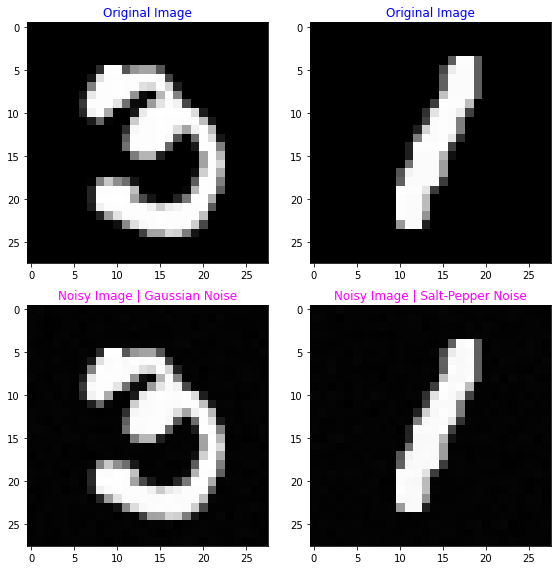

In [ ]:
image_idx = np.random.randint(0,round((len(X_train)/2)-1),size = 2)
# noisy_image_idx = np.random.randint(round((len(X_train)/2)+1),len(X_train),size = 2)


fig, axes=plt.subplots(2,2,figsize=(8, 8))
fig.tight_layout()

# Visualize images where we have added Gaussian Noise
axes[0,0].imshow(X_train[image_idx[0]],cmap="gray")
axes[0,0].set_title("Original Image",color="Blue")
axes[1,0].imshow(df_train[image_idx[0]],cmap='gray')
axes[1,0].set_title("Noisy Image | Gaussian Noise",color="magenta")

# Visualize images where we have added Salt_Pepper Noise
axes[0,1].imshow(X_train[image_idx[1]],cmap='gray')
axes[0,1].set_title("Original Image",color="Blue")
axes[1,1].imshow(df_train[image_idx[1]],cmap="gray")
axes[1,1].set_title("Noisy Image | Salt-Pepper Noise",color="magenta");

In [ ]:
class f_Noisy_Dataset(Dataset):
    
    def __init__(self,DF_Noisy,DF_Clean,Labels,Transformation):
        self.noise = DF_Noisy
        self.clean = DF_Clean
        self.labels = Labels
        self.transform = Transformation
    
    def __len__(self):
        return len(self.noise)
    
    def __getitem__(self,idx):
        
        x_noise = self.noise[idx]
        x_clean = self.clean[idx]
        y = self.labels[idx]
        
        if self.transform != None:
            x_noise = self.transform(x_noise)
            x_clean = self.transform(x_clean)
        
        return (x_noise,x_clean,y)

In [ ]:
# Pytorch requires the data to be in tensor form. Thus, we will transform our data into tensors.
# We are also normalizing the data 
transformation_layer = transforms.Compose([transforms.ToTensor(),
                                           #transforms.Normalize((0.5,), (0.5,))
                                          ])

In [ ]:
trainset = f_Noisy_Dataset(df_train,X_train,y_train,transformation_layer)

In [ ]:
testset = f_Noisy_Dataset(df_test,X_test,y_test,transformation_layer)

In [ ]:
Batch_Size = 32
Learning_Rate = 0.001

In [ ]:
trainloader = DataLoader(trainset,batch_size=Batch_Size,shuffle=True)
testloader = DataLoader(testset,batch_size=Batch_Size,shuffle=True)

In [ ]:
# Autoencoder model with 3 encoder and 3 decoder layers

class Denoising_Autoencoder_3_3(nn.Module):
    
    def __init__(self):
        
        super(Denoising_Autoencoder_3_3,self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(28*28,256),
                                     nn.ReLU(True),
                                     nn.Linear(256,128),
                                     nn.ReLU(True),
                                     nn.Linear(128,64),
                                     nn.ReLU(True))
        
        self.decoder = nn.Sequential(nn.Linear(64,128),
                                     nn.ReLU(True),
                                     nn.Linear(128,256),
                                     nn.ReLU(True),
                                     nn.Linear(256,28*28),
                                     nn.Sigmoid(),)
    
    def forward(self,x):
        
        x = self.encoder(x)
        x = self.decoder(x)
    
        return x
  

In [ ]:
# 1 FC Layer with Relu activation function

class Denoising_Autoencoder_1_Relu(nn.Module):
    
    def __init__(self):
        
        super(Denoising_Autoencoder_1_Relu,self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(28*28,256),
                                     nn.ReLU(True))
        
        self.decoder = nn.Sequential(nn.Linear(256,28*28),
                                     nn.ReLU())
    
    def forward(self,x):
        
        x = self.encoder(x)
        x = self.decoder(x)
    
        return x
  

In [ ]:
# 1 FC Layer with Sigmoid activation functions

class Denoising_Autoencoder_1_Sigmoid(nn.Module):
    
    def __init__(self):
        
        super(Denoising_Autoencoder_1_Sigmoid,self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(28*28,256),
                                     nn.Sigmoid())
        
        self.decoder = nn.Sequential(nn.Linear(256,28*28),
                                     nn.Sigmoid())
    
    def forward(self,x):
        
        x = self.encoder(x)
        x = self.decoder(x)
    
        return x
  

In [ ]:
# 3 FC Layer and Relu activation functions

class Denoising_Autoencoder_3_Relu(nn.Module):
    
    def __init__(self):
        
        super(Denoising_Autoencoder_3_Relu,self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(28*28,256),
                                     nn.ReLU(True),
                                     nn.Linear(256,128),
                                     nn.ReLU(True),
                                     nn.Linear(128,64),
                                     nn.ReLU(True))
        
        self.decoder = nn.Sequential(nn.Linear(64,128),
                                     nn.ReLU(True),
                                     nn.Linear(128,256),
                                     nn.ReLU(True),
                                     nn.Linear(256,28*28),
                                     nn.Sigmoid(),)
    
    def forward(self,x):
        
        x = self.encoder(x)
        x = self.decoder(x)
    
        return x
  
  

In [ ]:
# 3 FC Layer and Sigmoid activation functions

class Denoising_Autoencoder_3_Sigmoid(nn.Module):
    
    def __init__(self):
        
        super(Denoising_Autoencoder_3_Sigmoid,self).__init__()
        
        self.encoder = nn.Sequential(nn.Linear(28*28,256),
                                     nn.Sigmoid(),
                                     nn.Linear(256,128),
                                     nn.Sigmoid(),
                                     nn.Linear(128,64),
                                     nn.Sigmoid())
        
        self.decoder = nn.Sequential(nn.Linear(64,128),
                                     nn.Sigmoid(),
                                     nn.Linear(128,256),
                                     nn.Sigmoid(),
                                     nn.Linear(256,28*28),
                                     nn.Sigmoid(),)
    
    def forward(self,x):
        
        x = self.encoder(x)
        x = self.decoder(x)
    
        return x
  
  

**Specify the model by un-commenting it**

In [ ]:
# DAE_Model = Denoising_Autoencoder_3_3()

In [ ]:
# DAE_Model = Denoising_Autoencoder_1_Relu()

In [ ]:
# DAE_Model = Denoising_Autoencoder_1_Sigmoid()

In [ ]:
# DAE_Model = Denoising_Autoencoder_3_Relu()

In [ ]:
DAE_Model = Denoising_Autoencoder_3_Sigmoid()

In [ ]:
criterion = nn.MSELoss()
#optimizer = optim.SGD(DAE_Model.parameters(),lr=0.01,weight_decay=1e-5)
optimizer = torch.optim.Adam(params = DAE_Model.parameters(),
                             lr = Learning_Rate,
                             weight_decay = 1e-5)

In [ ]:
DAE_Model.parameters

<bound method Module.parameters of Denoising_Autoencoder_3_Sigmoid(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Sigmoid()
  )
)>

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

summary(DAE_Model)

Layer (type:depth-idx)                   Param #
Denoising_Autoencoder_3_Sigmoid          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200,960
│    └─Sigmoid: 2-2                      --
│    └─Linear: 2-3                       32,896
│    └─Sigmoid: 2-4                      --
│    └─Linear: 2-5                       8,256
│    └─Sigmoid: 2-6                      --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       8,320
│    └─Sigmoid: 2-8                      --
│    └─Linear: 2-9                       33,024
│    └─Sigmoid: 2-10                     --
│    └─Linear: 2-11                      201,488
│    └─Sigmoid: 2-12                     --
Total params: 484,944
Trainable params: 484,944
Non-trainable params: 0

In [ ]:
Num_Epochs = 25

size = len(trainloader)
Loss_List = list()
Epoch_Loss = 0
Running_Loss = 0

In [ ]:
for epoch in range(Num_Epochs):
    
    print(f'Epoch: {epoch}')
    
    for noisy,original,label in tqdm((trainloader)):
        
        noisy = noisy.view(noisy.size(0),-1).type(torch.FloatTensor)
        original = original.view(original.size(0),-1).type(torch.FloatTensor)
        #noisy,original = noisy.to(device),original.to(device)
        
        #-------------
        # Forward Pass
        #-------------
        
        output = DAE_Model(noisy)
        loss = criterion(output,original)
        
        #---------------
        # Backward Pass
        #---------------
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        Running_Loss += loss.item()
        Epoch_Loss += loss.item()
        
    #-----------------Log-------------------------------
    Loss_List.append(Running_Loss/size)
    Running_Loss=0
    print(f'Epoch : {epoch}/{Num_Epochs} || Loss : {loss.item()} ')

Epoch: 0


100%|██████████| 1875/1875 [00:23<00:00, 79.21it/s]


Epoch : 0/25 || Loss : 0.06107838451862335 
Epoch: 1


100%|██████████| 1875/1875 [00:16<00:00, 112.71it/s]


Epoch : 1/25 || Loss : 0.059006281197071075 
Epoch: 2


100%|██████████| 1875/1875 [00:14<00:00, 131.98it/s]


Epoch : 2/25 || Loss : 0.045665591955184937 
Epoch: 3


100%|██████████| 1875/1875 [00:13<00:00, 135.39it/s]


Epoch : 3/25 || Loss : 0.04990819841623306 
Epoch: 4


100%|██████████| 1875/1875 [00:13<00:00, 136.43it/s]


Epoch : 4/25 || Loss : 0.046855587512254715 
Epoch: 5


100%|██████████| 1875/1875 [00:13<00:00, 135.05it/s]


Epoch : 5/25 || Loss : 0.04901736602187157 
Epoch: 6


100%|██████████| 1875/1875 [00:13<00:00, 135.99it/s]


Epoch : 6/25 || Loss : 0.04556320235133171 
Epoch: 7


100%|██████████| 1875/1875 [00:13<00:00, 134.32it/s]


Epoch : 7/25 || Loss : 0.04269271343946457 
Epoch: 8


100%|██████████| 1875/1875 [00:14<00:00, 129.94it/s]


Epoch : 8/25 || Loss : 0.045217566192150116 
Epoch: 9


100%|██████████| 1875/1875 [00:13<00:00, 136.20it/s]


Epoch : 9/25 || Loss : 0.04256027191877365 
Epoch: 10


100%|██████████| 1875/1875 [00:13<00:00, 141.75it/s]


Epoch : 10/25 || Loss : 0.04091893509030342 
Epoch: 11


100%|██████████| 1875/1875 [00:13<00:00, 141.34it/s]


Epoch : 11/25 || Loss : 0.04118088632822037 
Epoch: 12


100%|██████████| 1875/1875 [00:13<00:00, 139.76it/s]


Epoch : 12/25 || Loss : 0.04108403995633125 
Epoch: 13


100%|██████████| 1875/1875 [00:13<00:00, 137.93it/s]


Epoch : 13/25 || Loss : 0.04259438440203667 
Epoch: 14


100%|██████████| 1875/1875 [00:13<00:00, 141.15it/s]


Epoch : 14/25 || Loss : 0.03858104348182678 
Epoch: 15


100%|██████████| 1875/1875 [00:13<00:00, 138.56it/s]


Epoch : 15/25 || Loss : 0.037380967289209366 
Epoch: 16


100%|██████████| 1875/1875 [00:13<00:00, 138.89it/s]


Epoch : 16/25 || Loss : 0.04045109078288078 
Epoch: 17


100%|██████████| 1875/1875 [00:14<00:00, 132.32it/s]


Epoch : 17/25 || Loss : 0.04095170274376869 
Epoch: 18


100%|██████████| 1875/1875 [00:14<00:00, 128.59it/s]


Epoch : 18/25 || Loss : 0.03561883047223091 
Epoch: 19


100%|██████████| 1875/1875 [00:13<00:00, 137.57it/s]


Epoch : 19/25 || Loss : 0.03878268599510193 
Epoch: 20


100%|██████████| 1875/1875 [00:13<00:00, 138.90it/s]


Epoch : 20/25 || Loss : 0.035662829875946045 
Epoch: 21


100%|██████████| 1875/1875 [00:13<00:00, 138.10it/s]


Epoch : 21/25 || Loss : 0.035432640463113785 
Epoch: 22


100%|██████████| 1875/1875 [00:13<00:00, 138.33it/s]


Epoch : 22/25 || Loss : 0.039964158087968826 
Epoch: 23


100%|██████████| 1875/1875 [00:13<00:00, 138.75it/s]


Epoch : 23/25 || Loss : 0.03751695156097412 
Epoch: 24


100%|██████████| 1875/1875 [00:13<00:00, 138.93it/s]

Epoch : 24/25 || Loss : 0.04298705607652664 


In [ ]:
Loss_List

[0.06247741556167603,
 0.05907336628039678,
 0.05503737176060677,
 0.05259791781703631,
 0.05132460253238678,
 0.05074910262425741,
 0.05026782944003741,
 0.048348184732596076,
 0.04600996192296346,
 0.04522026614745458,
 0.04366600165764491,
 0.04266497615973155,
 0.04205268204013506,
 0.04138173732558886,
 0.04061224405368169,
 0.0401526851306359,
 0.03986414938370387,
 0.0395546448469162,
 0.03912324425081412,
 0.03867268392642339,
 0.038344208697477976,
 0.03818614280621211,
 0.03811052007277806,
 0.038036128717660905,
 0.03791924812495708]

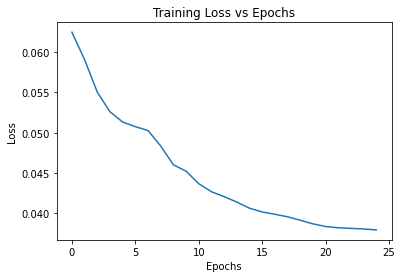

In [ ]:
plt.plot(range(len(Loss_List)),Loss_List);
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.show();

**Visualize a sample of results**

Text(0.5, 1.0, 'Original Image')

Text(0.5, 1.0, 'Noisy Image')

Text(0.5, 1.0, 'Cleaned Image')

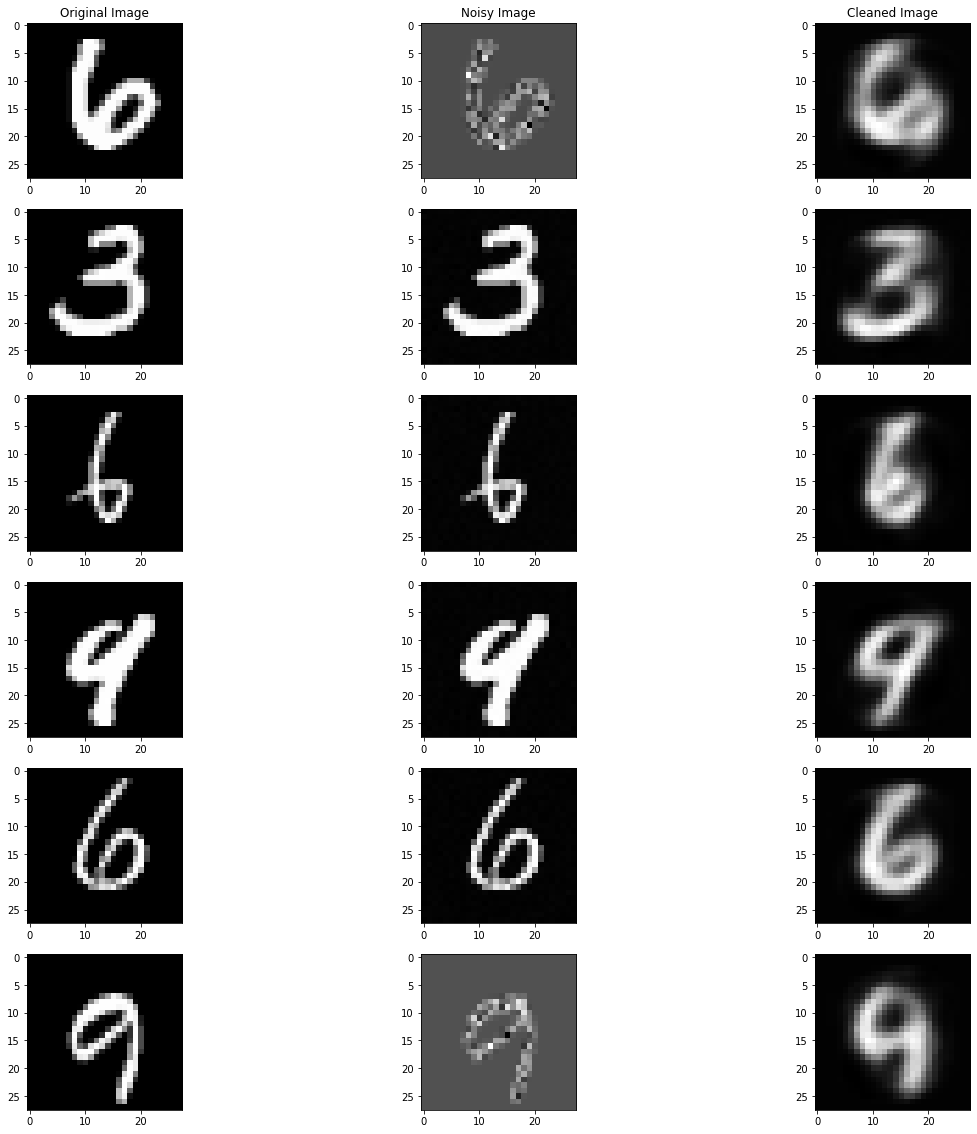

In [ ]:
f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Noisy Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,10000,size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  #dirty=dirty.to(device)
  output=DAE_Model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")